# Uso del Machine Learning para predecir el riesgo de perdida de clientes en el banco BETA BANK

La empresa bancaria Beta Bank esta experimentando la perdida de clientes, mes a mes lo clientes estan cerrando suys cuentas con el banco. Los analistas financieron descubrieron que es mas economico salvar a los clientes existentes que atraer nuevos.

Tenemos acceso a los datos sobre el comportamiento pasado de los clientes y sobre aquellos que han dado de baja a los contratos con el banco.

Desarrollaremos un modelo que nos permita predecir si un cliente dejará el banco pronto. El modelo debe obtener un valor de `metrica F1 de al menos 0.59`. Además, mediremos la `métrica AUC-ROC`.


Para el desarrollo del modelo usaremos la dataset `Churn` y aplicaremos los siguientes algoritmos de machine learning:

- Logistic Regression
- Decision Tree
- Random Forest

Los datos generales se dividirán en conjuntos de entrenamiento, validación y prueba. Los modelos se entrenarán y ajustarán utilizando los conjuntos de entrenamiento y validación, con el objetivo de optimizar los hiperparámetros para lograr la máxima exactitud. Una vez establecidos los hiperparámetros óptimos, los modelos se evaluarán utilizando el conjunto de prueba y se seleccionará el que tenga la mayor exactitud como modelo final.

### 1.- IMPORTAMOS LIBRERIAS

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Hide warning messages
import warnings
warnings.filterwarnings('ignore')

### 2.-  CARGA DE LA DATA

El archivo csv `Churn` sera leido y almacenado en la dataframe `df`.

In [ ]:
df = pd.read_csv('../SP 10 BETABANK PREDICCION DE BAJA DE CLIENTE/dataset/Churn.csv')

### 3.- EXPLORANDO LA DATA

### 3.1 Descripcion de los datos:

#### Características

- `RowNumber`: índice de cadena de datos
- `CustomerId`: identificador de cliente único
- `Surname`: apellido
- `CreditScore`: valor de crédito
- `Geography`: país de residencia
- `Gender`: sexo
- `Age`: edad
- `Tenure`: período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
- `Balance`: saldo de la cuenta
- `NumOfProducts`: número de productos bancarios utilizados por el cliente
- `HasCrCard`: el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
- `IsActiveMember`: actividad del cliente (1 - sí; 0 - no)
- `EstimatedSalary`: salario estimado

#### Objetivo

- `Exited`: El cliente se ha ido (1 - sí; 0 - no)

In [13]:
# Mostramos la data
print(df.info()) 
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


RowNumber  CustomerId     Surname  CreditScore Geography  Gender  Age  \
6127       6128    15708693     Sherman          759    France  Female   33   
8756       8757    15784923    Chimezie          705   Germany  Female   37   
5523       5524    15625586     Monaldo          717    France    Male   35   
9729       9730    15615330  Tretiakova          651    France    Male   23   
7013       7014    15599440    McGregor          748    France  Female   34   
9078       9079    15705448     Gilbert          647   Germany    Male   52   
9938       9939    15593496     Korovin          526     Spain  Female   36   
81           82    15663706     Leonard          777    France  Female   32   
3511       3512    15674727     Lazarev          777    France  Female   42   
4665       4666    15656293       Davey          786    France    Male   35   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
6127     2.0       0.00              2          1               0   
8756     3.0  109974.22              1          1               1   
5523     4.0       0.00              1          1               1   
9729    10.0       0.00              2          1               1   
7013     NaN       0.00              2          1               0   
9078     7.0  130013.12              1          1               1   
9938     NaN   91132.18              1          0               0   
81       2.0       0.00              1          1               0   
3511     5.0  147531.82              1          1               1   
4665     3.0       0.00              2          1               0   

      EstimatedSalary  Exited  
6127         56583.88       0  
8756         36320.87       1  
5523        167573.06       0  
9729        170099.23       0  
7013         53584.03       0  
9078        190806.36       1  
9938         58111.71       0  
81          136458.19       1  
3511         38819.45       0  
4665         92712.97       0

La dataframe `df` tiene 10,000 filas and 14 columns. 

Observaciones: 
- La columna `Tenure` tiene `909` valores perdidos, el cual corresponde al 9% de la data por lo que no podemos eliminar las filas y la data de la columan debe ser completada con la media de los valores de `Ternure`. 
- La columna `RowNumber`, `CustomerId `, `Surname`, `Geography` y `Gender` no aportan como caracteristicas al modelo, debido a que son datos strings o no numericos, por lo que seran procesadas en la etapa de modelamiento mediante metodos de codificacion.

### 3.2 Pre procesamiento de datos:

Los datos perdidos de la columna `Tenure` seran reemplazdos por la media de la columna.

In [16]:
# Filtramos las filas perdidos con .isna() dentro de .loc() para seleccionar las filas NaN de la columna 'Ternure'
# Estos datos seran iguales a la media de la columa 'Ternure' para lo cual usamos .median()

df.loc[df['Tenure'].isna(),'Tenure'] = df['Tenure'].median()

Exploramos nuevamente la dataframe para cerciorarnos que la data perdida ha sido rellenada.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


## 4.- MODELAMIENTO

### 4.1 Preparacion de las caracteristicas:

Antes de dividir la datra y entrenar el modelo, debemos preparar las caracteristicas, esta debe ser data numerica para evitar errores, por lo que cualquier columna no-numerica o strings debe ser transformado usando metodos de codificacion. Asimismo, otra condicion para codificar los datos es que estos deben contener pocos valores unicos, por lo que contaremos los valores unicos de las columnas.

In [ ]:
a = df.columns
for i in a:
    print(i,' - tiene: ', df[i].nunique(), 'valores unicos')

RowNumber  - tiene:  10000 valores unicos
CustomerId  - tiene:  10000 valores unicos
Surname  - tiene:  2932 valores unicos
CreditScore  - tiene:  460 valores unicos
Geography  - tiene:  3 valores unicos
Gender  - tiene:  2 valores unicos
Age  - tiene:  70 valores unicos
Tenure  - tiene:  11 valores unicos
Balance  - tiene:  6382 valores unicos
NumOfProducts  - tiene:  4 valores unicos
HasCrCard  - tiene:  2 valores unicos
IsActiveMember  - tiene:  2 valores unicos
EstimatedSalary  - tiene:  9999 valores unicos
Exited  - tiene:  2 valores unicos


Las columnas `RowNumber`, `CustomerId` y `Surname` tienen entre 2932 y 10000 valores unicos por lo que no podemos codificarlos, ademas, no impactan dentro de las caracteristicas para la evaluacion de abandono de clientes, por lo que se creara una nueva dataframe llamada `data_filtrada` la cual sera creada removiendo las columnas `RowNumber`, `CustomerId` y `Surname` .

In [86]:
data_filtrada = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Ahora las columnas `Geography` y `Gender`tienen 3 y 2 valores unicos respectivamente, realizaremos One-Hot Encoding un metodo adecuado para codificar variables categoricas ideal para los algoritmos `Logistic Regression`, `Decision Tree` y `Random Forest` que evaluaremos.

La dataframe codificada se llamara `data_OHE` y para evitar la trampa dummy utilizaremos el parametro `drop_first=True` dentro de la codificacion One-Hot `pd.get_dummies()`

In [ ]:
# Codificacion ONE-HOT de la dataframe data_filtrada
# Parametro drop_first=True, para eliminar la primera columna codificacda y evitar la trampoa dummyt
# Parametro dtype= int, para que las columnas generadas como data dummy sean de tipo int
data_OHE = pd.get_dummies(data_filtrada, drop_first=True, dtype= int)


Luego de la codificacion One-Hot, hecharemos un vistazo a la dataframe `data_ohe`

In [88]:
data_OHE

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619   42     2.0       0.00              1          1   
1             608   41     1.0   83807.86              1          0   
2             502   42     8.0  159660.80              3          1   
3             699   39     1.0       0.00              2          0   
4             850   43     2.0  125510.82              1          1   
...           ...  ...     ...        ...            ...        ...   
9995          771   39     5.0       0.00              2          1   
9996          516   35    10.0   57369.61              1          1   
9997          709   36     7.0       0.00              1          0   
9998          772   42     3.0   75075.31              2          1   
9999          792   28     5.0  130142.79              1          1   

      IsActiveMember  EstimatedSalary  Exited  Geography_Germany  \
0                  1        101348.88       1                  0   
1                  1        112542.58       0                  0   
2                  0        113931.57       1                  0   
3                  0         93826.63       0                  0   
4                  1         79084.10       0                  0   
...              ...              ...     ...                ...   
9995               0         96270.64       0                  0   
9996               1        101699.77       0                  0   
9997               1         42085.58       1                  0   
9998               0         92888.52       1                  1   
9999               0         38190.78       0                  0   

      Geography_Spain  Gender_Male  
0                   0            0  
1                   1            0  
2                   0            0  
3                   0            0  
4                   1            0  
...               ...          ...  
9995                0            1  
9996                0            1  
9997                0            0  
9998                0            1  
9999                0            0  

[10000 rows x 12 columns]

Las 3 ulitmas columnas son el resultado de codificar las columnas `Geography` y `Gender`. Toda la dataframe es ahora numerica y lista para entrenar.

### 4.2 Division de los conjuntos de datos:

Queremos poder entrenar el modelo, validarlo y luego realizar las pruebas finales del modelo. Estas acciones requieren 3 conjuntos de datos separados. Dado que Beta Bank solo ha proporcionado un conjunto de datos, se dividirá en un conjunto de datos de entrenamiento, un conjunto de datos de validación y un conjunto de datos de prueba. Una proporción popular para dividir los datos es 3:1:1, donde el conjunto de datos de entrenamiento contiene el 60 % de los datos y tanto el conjunto de datos de validación como el de prueba contienen el 20 % de los datos. Para dividir los datos, utilizaremos la función `train_test_split` que se encuentra en la biblioteca `sklearn.model_selection`. El siguiente bloque de celdas dividirá el conjunto de datos general en 3 conjuntos de datos separados.

In [94]:
# Creamos los conjuntos de datos de entrenamiento (train), validacion (valid) y prueb (test)
# La dataframe sera divida en 60%, 20%, 20% para una relacion de 3:1:1.

# Creamos la df 'target' compuesta por la columna 'Exited'
target = data_OHE['Exited']

# Creamos la df 'features' retirando la clumna 'Exited'
features = data_OHE.drop('Exited', axis=1)

# Dividimos la df target y features en dataset 'training' y 'other' con el 60%  y 40 de la data respectivamente.
features_train, features_other, target_train, target_other = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)

# Dividiremos la dataset 'other'en las dataset de validation y testing
# El parametro test_size sera 0.5 para que cada dataset contenga el 50% del 40% de la data
# O el 20% del total de la data respectivament.
features_valid, features_test, target_valid, target_test = train_test_split(features_other,
                                                                            target_other, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)

### 4.3 Prueba de consistencia:

Ahora que los datos se han dividido, examinemos la distribución de clases positivas y negativas en cada conjunto de datos. Calcularemos la proporción de instancias positivas y negativas en cada uno de los conjuntos de datos de entrenamiento, validación y prueba y mostraremos los resultados.

Target_Train
El balance de clases para Target_Train es:  Exited
0    80.07
1    19.93
Name: proportion, dtype: float64 


Target_Valid
El balance de clases para Target_Valid es:  Exited
0    79.1
1    20.9
Name: proportion, dtype: float64 


Target_Test
El balance de clases para Target_Test es:  Exited
0    78.85
1    21.15
Name: proportion, dtype: float64 




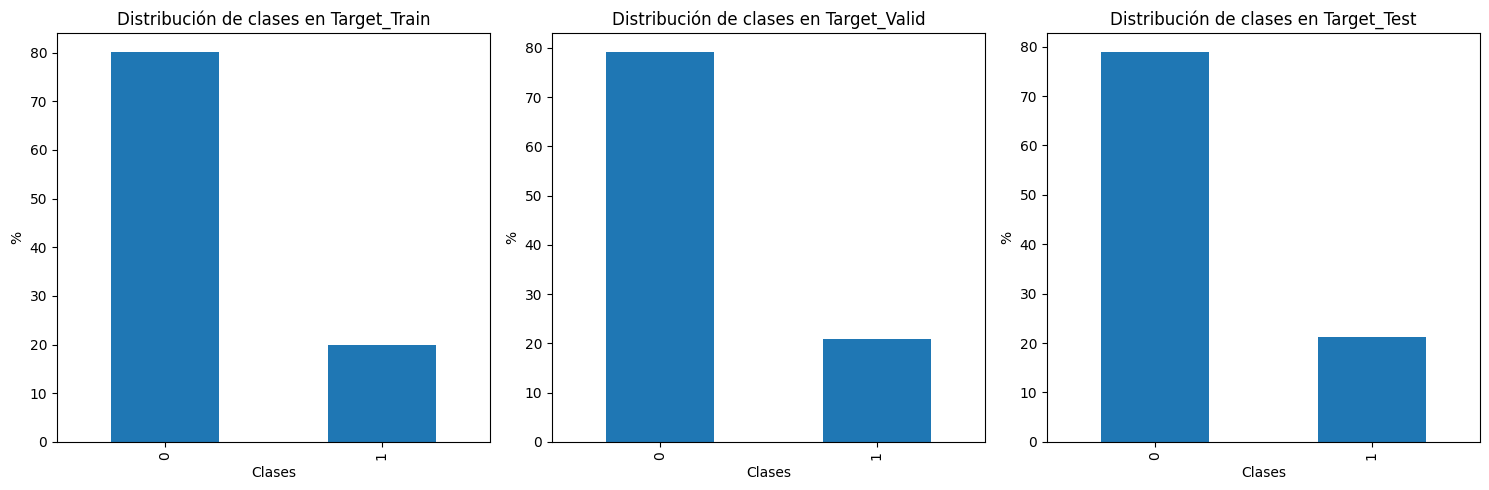

In [171]:
# Lista de DataFrames y sus nombres
datasets = [target_train, target_valid, target_test]
dataset_names = ['Target_Train', 'Target_Valid', 'Target_Test']

# Crear una figura para los gráficos
plt.figure(figsize=(15, 5))  # Tamaño de la figura (ancho, alto)

# Ciclo para iterar sobre los datasets y graficar
for i, (dataset, name) in enumerate(zip(datasets, dataset_names)):
    # Obtener los conteos de valores en la columna 'columna'
    counts = round(dataset.value_counts(normalize=True)* 100,2)
    print(name)
    print(f'El balance de clases para {name} es: ', counts,'\n\n')
    

    # Crear el gráfico de barras en una subgráfica (subplot)
    plt.subplot(1, 3, i + 1)  # 1 fila, 3 columnas, y el gráfico en la posición i+1
    counts.plot(kind='bar')
    
    # Agregar título y etiquetas
    plt.title(f"Distribución de clases en {name}")
    plt.xlabel('Clases')
    plt.ylabel('%')

# Ajustar el layout para que los gráficos no se sobrepongan
plt.tight_layout()

# Mostrar los gráficos
plt.show()

El desequilibrio de clases significativo se puede observar en los conjuntos de datos de objetivos de `train`, `valid` y `test` donde la clase negativa (0) constituye el 80% mientras que la clase positiva (1) solo representa el 20%. Para mejorar la capacitación y los resultados del modelo, es necesario corregir este desequilibrio. Para demostrar el impacto de la corrección del equilibrio de clases, compararemos el rendimiento de un modelo entrenado sin corrección del equilibrio de clases con otro modelo entrenado después de la corrección. Antes del entrenamiento, debemos estandarizar los datos para tratar cada característica por igual usando la clase `StandardScaler` del módulo `sklearn.preprocessing`, que se realiza en el siguiente bloque de celdas.

### 4.4 Estandarizacion de caracteristicas:
Estandarizaremos las caracteristicas (features) de los dataset para que el modelo interpete las caracteristicas por igual y no exista una mas importante que otra debido a su valor numerico.

In [172]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

Ahora que los datos están estandarizados para los conjuntos de datos de `train`, `valid` y `test`.

### 4.5 Entrenamiento de modelos:

Entrenaremos los modelos usando los siguientes algoritmos:

- Logistic Regression
- Decision Tree
- Random Forest

Evaluaremos las metricas `F1` y  `AUC_ROC` para cada modelo y compararemos los modelos ajustando el `balance de clases`, `el peso de la clase`, `el sobremuestreo` y `el submuestreo`.

#### 4.5.1 Logistic Regression:

#### Training a model before adjusting class imbalance

Let's first train a model without having adjusted the class imbalance. Then, we will compare the results with a trained model after having adjusted the class imbalance.

In [13]:
# Create an instance of a LogisticRegression model
model = LogisticRegression(solver='liblinear', random_state=12345)

# Fit the model using the training data
model.fit(features_train, target_train)

# Predict the target values of the validation features
predicted_valid = model.predict(features_valid)

# Calculate and print the F1 score
print('F1:', round(f1_score(target_valid, predicted_valid),5))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC Score: {round(auc_roc, 5)}')

F1: 0.33108
AUC-ROC Score: 0.75875


The logistic regression model's F1 score is about 0.33 without class imbalance adjustment, which is decent but not satisfactory. This model wouldn't be suitable for Beta Bank. The AUC-ROC score is roughly 0.76, which is better than a random model, but still not ideal. Let's evaluate the model's performance after adjusting the class imbalance.

#### Training a model after adjusting the class imbalance

To improve the F1 score of the logistic regression model, we'll attempt to balance the class imbalance in the training dataset. By adjusting the class weight, the model will become aware of the most frequent classes. This can be achieved by setting the `class_weight` parameter to `balanced` when initializing the model.

In [14]:
# Create an instance of a LogisticRegression model
# pass the parameter class_weight='balanced'
model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=12345)

# Fit the model using the training data
model.fit(features_train, target_train)

# Predict the target values of the validation features
predicted_valid = model.predict(features_valid)

# Calculate and print the F1 score
print('F1:', round(f1_score(target_valid, predicted_valid),5))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC Score: {round(auc_roc, 5)}')

F1: 0.48885
AUC-ROC Score: 0.76373


After balancing the class imbalance, the logistic regression model's F1 score improved to approximately 0.49, compared to the previous score of 0.33. Although the score improved, it still falls short of the required minimum of 0.59 set by Beta Bank. The AUC-ROC score also improved slightly. We will now try other methods for adjusting class imbalance and train different models to find the best solution.

### Adjusting class weight with upsampling and downsampling

Rephrased: To further address the class imbalance, besides using `class_weight='balanced'`, we can also apply upsampling and downsampling techniques. Upsampling increases the occurrence of positive instances, while downsampling reduces the number of negative instances. Let's first examine upsampling and create a function for it.

#### Upsampling

In [15]:
# Adjust class imablance with upsampling

# Create a function for upsampling the training data

# Initialize the funciton
def upsample(features, target, repeat):
    
    # Create datasets based on class
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # Perform upsampling
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # Shuffle the observations
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    # Return the upsampled data
    return features_upsampled, target_upsampled

Now that a function has been created for upsampling, let's pass the features and target datasets of the training dataset to the function.

In [16]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

Now let's see how upsampling effects the performance of the Logistic Regression model.

In [17]:
# Create an instance of a LogisticRegression model
# pass the parameter class_weight='balanced'
model = LogisticRegression(solver='liblinear', random_state=12345)

# Fit the model using the training data
model.fit(features_upsampled, target_upsampled)

# Predict the target values of the validation features
predicted_valid = model.predict(features_valid)

# Calculate and print the F1 score
print('F1:', round(f1_score(target_valid, predicted_valid),5))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC Score: {round(auc_roc, 5)}')

F1: 0.41943
AUC-ROC Score: 0.76535


The F1 score of the model after upsampling the data is approximately 0.42, which is not as good as the previous score of approximately 0.49 obtained using the `class_weight` parameter. Nonetheless, it is better than not adjusting the class imbalance at all. The AUC-ROC score is similar to the one seen previously from the model with the `class_weight='balanced'` parameter. Now, let's try downsampling to see the effect on the model.

#### Downsampling

In [18]:
# Create a function for downsampling the training data

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

Now that a function has been created for downsampling, let's pass the features and target datasets of the training dataset to the function.

In [19]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

Now let's see how downsampling effects the performance of the Logistic Regression model.

In [20]:
# Create an instance of a LogisticRegression model
# pass the parameter class_weight='balanced'
model = LogisticRegression(solver='liblinear', random_state=12345)

# Fit the model using the training data
model.fit(features_downsampled, target_downsampled)

# Predict the target values of the validation features
predicted_valid = model.predict(features_valid)

# Calculate and print the F1 score
print('F1:', f1_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'AUC-ROC Score: {round(auc_roc, 5)}')

F1: 0.4308390022675737
AUC-ROC Score: 0.75836


The new model has an F1 score of about 0.43, which is an improvement over the model with upsampled data but not as good as the one using the class_weight parameter. The AUC-ROC score remains largely unchanged and has slightly decreased compared to the previous two models. With the exploration of Logistic Regression models complete, it's time to evaluate the performance of Decision Tree Classifier and Random Forest Classifier models.

## TRAINING OTHER TYPES OF MODELS

The following code will evaluate the performance of Decision Tree and Random Forest models when class imbalance is corrected. Each model's performance will be analyzed after correcting class imbalance using `class_weight`, upsampling and downsampling methods.

#### Decision Tree with class_weight='balanced'

In [21]:
# Decision Tree Model/Learning Algorithm

# Initialize
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Create various models with different depth values

# for loop for changing depth values (range of 1-41)
for depth in range(1,41):
    
    # Create a model, using the provided depth and the same random_state
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Train the model using the training dataset
    DT_model.fit(features_train, target_train)
    
    # Predict the target values of the validation features using the model
    DT_predictions_valid = DT_model.predict(features_valid) # get model predictions on validation set
    
    # Calculate the f1_score, if allowed
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break
        
    # Determe best fit
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1

probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_DT_model)
print(f'Best F1 Score: {round(best_DT_f1_score,4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_DT_depth)

Best Model: DecisionTreeClassifier(max_depth=6, random_state=12345)
Best F1 Score: 0.5697
AUC-ROC Score: 0.81646
Best Depth: 6


The Decision Tree model with `class_weight='balanced'` has the highest F1 score so far, around 0.57. The corresponding AUC-ROC score is also the highest observed till now.

#### Decision Tree using Upsampling

In [22]:
# Decision Tree Model/Learning Algorithm

# Initialize
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Create various models with different depth values

# for loop for changing depth values (range of 1-41)
for depth in range(1,41):
    
    # Create a model, using the provided depth and the same random_state
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Train the model using the training dataset
    DT_model.fit(features_upsampled, target_upsampled)
    
    # Predict the target values of the validation features using the model
    DT_predictions_valid = DT_model.predict(features_valid) # get model predictions on validation set
    
    # Calculate the f1_score, if allowed
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break
    
    # Determe best fit
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1

probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_DT_model)
print(f'Best F1 Score: {round(best_DT_f1_score,4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_DT_depth)

Best Model: DecisionTreeClassifier(max_depth=7, random_state=12345)
Best F1 Score: 0.5252
AUC-ROC Score: 0.8126
Best Depth: 7


The Decision Tree model with upsampled data has improved F1 score and AUC-ROC compared to Logistic Regression models, but the model with `class_weight='balanced'` parameter still shows better performance in terms of F1 score and AUC-ROC.

#### Decision Tree with Downsampling

In [23]:
# Initialize
best_DT_model = None
best_DT_f1_score = 0
best_DT_depth = 0

# Create various models with different depth values

# for loop for changing depth values (range of 1-41)
for depth in range(1,41):
    
    # Create a model, using the provided depth and the same random_state
    DT_model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    
    # Train the model using the training dataset
    DT_model.fit(features_downsampled, target_downsampled)
    
    # Predict the target values of the validation features using the model
    DT_predictions_valid = DT_model.predict(features_valid) # get model predictions on validation set
    
    # Calculate the f1_score, if allowed
    try:
        f1 = f1_score(target_valid, DT_predictions_valid)
    except:
        break
    
    # Determe best fit
    if f1 > best_DT_f1_score:
        best_DT_model = DT_model
        best_DT_depth = depth
        best_DT_f1_score = f1
        
probabilities_valid = best_DT_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_DT_model)
print(f'Best F1 Score: {round(best_DT_f1_score,4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_DT_depth)

Best Model: DecisionTreeClassifier(max_depth=5, random_state=12345)
Best F1 Score: 0.4955
AUC-ROC Score: 0.81491
Best Depth: 5


The Decision Tree model using downsampled training data has a better F1 score and AUC-ROC score than the Logistic Regression models, but not higher than the Logistic Regression model with the `class_weight='balanced'` parameter.

### Random Forest

#### Random Forest with class_weight='balanced'

In [24]:
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Create various models with different depth and estimator values

# for loop for the number of estimators
for est in range(1,21):
    
    # for loop for the depth value
    for depth in range (1, 41):
        
        # Create a model, using the provided depth, number of estimators, and the same random_state
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Train the model using the training dataset
        RF_model.fit(features_train, target_train)

        # Predict the target values of the validation features using the model
        RF_predictions_valid = RF_model.predict(features_valid) # get model predictions on validation set
       
        # Calculate the f1_score, if allowed
        #try:
        f1 = f1_score(target_valid, RF_predictions_valid)
        #except:
            #break

     # Determe best fit
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_RF_model)
print(f'Best F1 Score: {round(best_RF_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_RF_depth)
print('Best n_estimators:', best_est)

Best Model: RandomForestClassifier(max_depth=14, n_estimators=9, random_state=12345)
Best F1 Score: 0.6
AUC-ROC Score: 0.82229
Best Depth: 14
Best n_estimators: 9


The Random Forest model with the `class_weight='balanced'` parameter has the best F1 score yet, at approximately 0.6, exceeding the F1 score of the Decision Tree models. This score meets the minimum F1 score requirement of 0.59 set by Beta Bank. Furthermore, its AUC-ROC score of around 0.82 is the highest seen so far.

#### Random Forest with Upsampling

In [25]:
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Create various models with different depth and estimator values

# for loop for the number of estimators
for est in range(1,21):
    
    # for loop for the depth value
    for depth in range (1, 41):
        
        # Create a model, using the provided depth, number of estimators, and the same random_state
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Train the model using the training dataset
        RF_model.fit(features_upsampled, target_upsampled)

        # Predict the target values of the validation features using the model
        RF_predictions_valid = RF_model.predict(features_valid) # get model predictions on validation set
       
        # Calculate the f1_score, if allowed
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break

     # Determe best fit
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_RF_model)
print(f'Best F1 Score: {round(best_RF_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_RF_depth)
print('Best n_estimators:', best_est)

Best Model: RandomForestClassifier(max_depth=14, n_estimators=20, random_state=12345)
Best F1 Score: 0.6093
AUC-ROC Score: 0.82729
Best Depth: 14
Best n_estimators: 20


The Random Forest model with upsampled data has a higher F1 score and AUC-ROC score than the model with the `class_weight='balanced'` parameter, with an F1 score of approximately 0.61 and an AUC-ROC score of approximately 0.83, the highest seen so far.

#### Random Forest with Downsampling

In [26]:
best_RF_model = None
best_est = 0
best_RF_depth = 0
best_RF_f1_score = 0

# Create various models with different depth and estimator values

# for loop for the number of estimators
for est in range(1,21):
    
    # for loop for the depth value
    for depth in range (1, 41):
        
        # Create a model, using the provided depth, number of estimators, and the same random_state
        RF_model = RandomForestClassifier(max_depth=depth, random_state=12345, n_estimators=est)
        
        # Train the model using the training dataset
        RF_model.fit(features_downsampled, target_downsampled)

        # Predict the target values of the validation features using the model
        RF_predictions_valid = RF_model.predict(features_valid) # get model predictions on validation set
       
        # Calculate the f1_score, if allowed
        try:
            f1 = f1_score(target_valid, RF_predictions_valid)
        except:
            break

     # Determe best fit
        if f1 > best_RF_f1_score:
            best_RF_model = RF_model
            best_RF_f1_score = f1
            best_RF_depth = depth
            best_est = est

probabilities_valid = best_RF_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Best Model:', best_RF_model)
print(f'Best F1 Score: {round(best_RF_f1_score, 4)}')
print(f'AUC-ROC Score: {round(auc_roc, 5)}')
print('Best Depth:', best_RF_depth)
print('Best n_estimators:', best_est)

Best Model: RandomForestClassifier(max_depth=15, n_estimators=10, random_state=12345)
Best F1 Score: 0.4781
AUC-ROC Score: 0.79146
Best Depth: 15
Best n_estimators: 10


Unfortunately, the downsampled Random Forest Classifier model did not perform well. Its F1 score of around 0.48 is one of the lowest values seen and comparable to the Logistic Regression models. However, the AUC-ROC score is still relatively high, better than other models and beats a random model by a large margin.

## Final testing

The top-performing model was the Random Forest Classifier with upsampled data, a max depth of 14, and n_estimators value of 20, based on its F1 score and AUC-ROC score. Let's train the model one more time and evaluate it using the test dataset.

In [27]:
# Perform Final Testing

# Create a model, using the provided depth, number of estimators, and the same random_state
RF_model = RandomForestClassifier(max_depth=14, random_state=12345, n_estimators=20)

# Train the model using the training dataset
RF_model.fit(features_upsampled, target_upsampled)

test_predictions = RF_model.predict(features_test)

f1 = f1_score(target_test, test_predictions)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(f'F1 Score: {round(f1, 4)}')
print(f'AUC-ROC score: {round(auc_roc, 4)}')

F1 Score: 0.5931
AUC-ROC score: 0.736


The Random Forest Classifier model that was trained has an F1 score of around 0.59, which meets Beta Bank's requirement. The AUC-ROC score is reasonable, as it outperforms a random model. However, it's lower than its previous performance on some validation datasets. We'll now check how many of the 2,000 customers in the test dataset are predicted to leave.

In [28]:
# Initialize total variable
total = 0

# Create a for loop for checking each prediction in the test predictions
for prediction in test_predictions:
    if prediction == 1:
        total += 1

# Print the total number of customers predicted to leave the bank
print(total)

474


Approximately 25% of the 2,000 customers in the test dataset, or 474 customers, are predicted to leave the bank. This is a significant number, and Beta Bank should consider sending promotions.

## Conclusion

The initial step in fulfilling Beta Bank's request was to preprocess the data and features. The features were transformed into numeric form by using One-Hot Encoding on categorical features. Finally, all features were standardized to ensure equal importance.

Once the data was preprocessed, we observed an imbalance in the target classes with the negative class accounting for around 80% and positive class accounting for only 20% of the data. To evaluate the performance, the Logistic Regression model was tested with the original class imbalance, and the other models were trained with adjustments made to balance the class imbalance.

The best performing model was determined by training Logistic Regression, Decision Tree, and Random Forest models. Each model was trained three times, with each type of model using a different method to adjust for the class imbalance in the target data. The first model of each type used the `class_weight='balanced'` parameter, the second model was trained on upsampled data, and the third model was trained on downsampled data.

The best performing model was the Random Forest Classifier trained with upsampled data using a max depth of 14 and n_estimators of 20. The model was tested on the test dataset and achieved an F1 score of 0.5931, which meets the minimum score requirement set by Beta Bank. This model is therefore considered a suitable solution for Beta Bank in predicting customer churn.